In [1]:
pip install pandas neo4j

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import os

file_path = "transactions.csv"

# Check if file exists and has content
if not os.path.exists(file_path) or os.stat(file_path).st_size == 0:
    print("⚠️ CSV file missing or empty. Creating sample transactions.csv...")
    
    sample_data = {
        "id": [1, 2, 3],
        "amount": [500.00, 1200.50, 750.00],
        "date": ["2024-02-19", "2024-02-18", "2024-02-17"],
        "type": ["debit", "credit", "debit"],
        "status": ["completed", "failed", "completed"],
        "account_from": [12345, 67890, 11111],
        "account_to": [67890, 12345, 22222]
    }

    df = pd.DataFrame(sample_data)
    df.to_csv(file_path, index=False)
    print("✅ Sample transactions.csv created!")

# Load the CSV file
transactions = pd.read_csv(file_path)
print(transactions.head())  # Verify data


⚠️ CSV file missing or empty. Creating sample transactions.csv...
✅ Sample transactions.csv created!
   id  amount        date    type     status  account_from  account_to
0   1   500.0  2024-02-19   debit  completed         12345       67890
1   2  1200.5  2024-02-18  credit     failed         67890       12345
2   3   750.0  2024-02-17   debit  completed         11111       22222


In [7]:
from neo4j import GraphDatabase

# Neo4j connection details
NEO4J_URI = "bolt://localhost:7687"  # Change if necessary
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "password"  # Replace with your actual password

def connect_to_neo4j():
    """Establish a connection to the Neo4j database."""
    try:
        driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
        print("Connected to Neo4j successfully!")
        return driver
    except Exception as e:
        print(f"Error connecting to Neo4j: {e}")
        return None


In [8]:
def insert_transactions(session, transactions):
    """Insert transaction data into Neo4j."""
    query = """
    UNWIND $transactions AS txn
    MERGE (t:Transaction {id: txn.id})
    SET t.amount = txn.amount, t.date = txn.date, t.type = txn.type,
        t.status = txn.status, t.account_from = txn.account_from, t.account_to = txn.account_to
    """
    
    transactions_dict = transactions.to_dict("records")  # Convert DataFrame to list of dictionaries
    session.run(query, transactions=transactions_dict)
    print("Transactions inserted successfully!")

# Execute the insertion process
if transactions is not None:
    with connect_to_neo4j() as driver:
        with driver.session() as session:
            insert_transactions(session, transactions)


Connected to Neo4j successfully!
Transactions inserted successfully!


In [9]:
def create_relationships(session):
    # Relationship for consecutive transactions (same account, sequential date)
    query = """
    MATCH (t1:Transaction), (t2:Transaction)
    WHERE t1.account_from = t2.account_from AND t1.date < t2.date
    MERGE (t1)-[:NEXT_TRANSACTION]->(t2)
    """
    session.run(query)
    print("✅ Consecutive transaction relationships created!")



In [10]:
def create_similar_transactions(session):
    query = """
    MATCH (t1:Transaction), (t2:Transaction)
    WHERE t1.type = t2.type AND t1.id <> t2.id 
    AND abs(t1.amount - t2.amount) < 0.05 * t1.amount
    MERGE (t1)-[:SIMILAR_TRANSACTION]->(t2)
    """
    session.run(query)
    print("✅ Similar transaction relationships created!")


In [12]:
def create_constraints(session):
    """
    Ensures that transaction IDs are unique in Neo4j.
    """
    query = """
    CREATE CONSTRAINT transaction_id_unique IF NOT EXISTS 
    FOR (t:Transaction) REQUIRE t.id IS UNIQUE;
    """
    session.run(query)
    print("✅ Constraints created to enforce unique transaction IDs.")


In [13]:
if __name__ == "__main__":
    file_path = "transactions.csv"
    transactions = load_data_from_csv(file_path)

    if transactions is not None:
        with connect_to_neo4j() as driver:
            with driver.session() as session:
                create_constraints(session)  # Ensure unique constraints
                insert_transactions(session, transactions)  # Insert transactions
                create_relationships(session)  # Link consecutive transactions
                create_similar_transactions(session)  # Link similar transactions
                print("🚀 Graph construction completed!")


✅ Data loaded successfully!
Connected to Neo4j successfully!
✅ Constraints created to enforce unique transaction IDs.
Transactions inserted successfully!
✅ Consecutive transaction relationships created!
✅ Similar transaction relationships created!
🚀 Graph construction completed!


In [14]:
from neo4j import GraphDatabase
import networkx as nx
import matplotlib.pyplot as plt

# Neo4j connection details
NEO4J_URI = "bolt://localhost:7687"  # Change if using a remote database
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "password"

def fetch_transactions():
    with GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD)) as driver:
        with driver.session() as session:
            query = """
            MATCH (t1:Transaction)-[r]->(t2:Transaction)
            RETURN t1.id AS source, t2.id AS target, type(r) AS relation
            """
            result = session.run(query)
            return [(record["source"], record["target"], record["relation"]) for record in result]

# Fetch transaction graph data
transactions = fetch_transactions()


In [17]:
def fetch_transactions():
    with GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD)) as driver:
        with driver.session() as session:
            query = """
            MATCH (t1:Transaction)-[r]->(t2:Transaction)
            RETURN t1.id AS source, t2.id AS target, type(r) AS relation
            """
            result = session.run(query)
            transactions = [(record["source"], record["target"], record["relation"]) for record in result]
            print("Fetched Transactions:", transactions)  # Debugging print
            return transactions

# Fetch data before visualization
transactions = fetch_transactions()

# If the list is empty, there are no relationships in Neo4j
if not transactions:
    print("No relationships found in the database!")
else:
    visualize_graph(transactions)


Fetched Transactions: []
No relationships found in the database!


In [18]:
def create_relationships(session):
    query = """
    MATCH (t1:Transaction), (t2:Transaction)
    WHERE t1.date < t2.date
    MERGE (t1)-[:NEXT]->(t2);
    """
    session.run(query)
    print("Relationships created!")

# Run this function in main()
with GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD)) as driver:
    with driver.session() as session:
        create_relationships(session)


Relationships created!


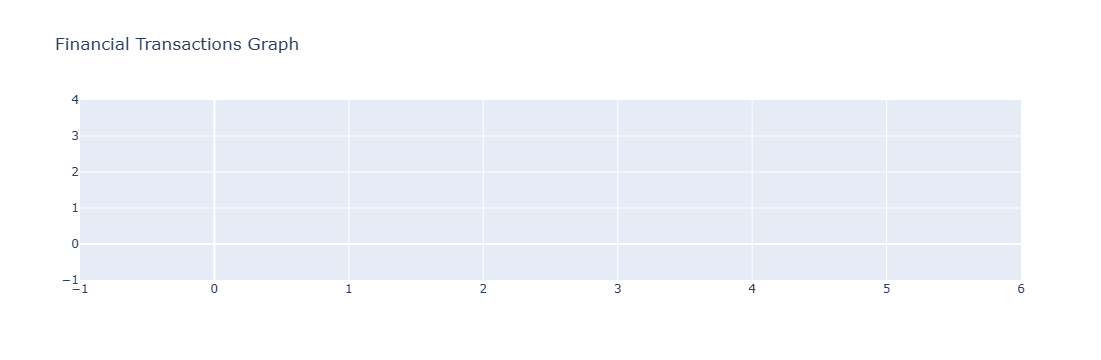

In [20]:
import plotly.graph_objects as go

def visualize_graph_plotly(transactions):
    G = nx.DiGraph()
    
    for source, target, relation in transactions:
        G.add_edge(source, target, label=relation)
    
    pos = nx.spring_layout(G, seed=42)
    
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color='gray'),
        hoverinfo='none',
        mode='lines'
    )
    
    node_x = []
    node_y = []
    node_text = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(str(node))
    
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=node_text,
        marker=dict(size=20, color='blue', line=dict(width=2, color='black')),
        textposition="top center"
    )
    
    fig = go.Figure(data=[edge_trace, node_trace])
    fig.update_layout(showlegend=False, title="Financial Transactions Graph")
    fig.show()

# Call interactive visualization
visualize_graph_plotly(transactions)


In [21]:
def detect_failure_modes(session):
    # High transaction frequency
    session.run("""
    MATCH (t:Transaction)
    WITH t.account_from AS account, COUNT(t) AS transaction_count
    WHERE transaction_count > 10
    MATCH (t:Transaction {account_from: account})
    SET t:Failure_HighFrequency
    """)

    # Large transactions
    session.run("""
    MATCH (t:Transaction)
    WHERE t.amount > 10000
    SET t:Failure_LargeTransaction
    """)

    # Repeated failed transactions
    session.run("""
    MATCH (t:Transaction)
    WHERE t.status = 'failed'
    WITH t.account_from AS account, COUNT(t) AS fail_count
    WHERE fail_count > 3
    MATCH (t:Transaction {account_from: account})
    SET t:Failure_RepeatedFailures
    """)

    print("Failure modes detected and tagged in Neo4j!")



In [22]:
import networkx as nx
import matplotlib.pyplot as plt

def fetch_graph_data():
    with GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD)) as driver:
        with driver.session() as session:
            query = """
            MATCH (t1:Transaction)-[r]->(t2:Transaction)
            RETURN t1.id AS source, t2.id AS target, type(r) AS relation, 
                   t1.amount AS amount, t1.status AS status,
                   CASE 
                        WHEN t1:Failure_HighFrequency THEN 'HighFrequency'
                        WHEN t1:Failure_LargeTransaction THEN 'LargeTransaction'
                        WHEN t1:Failure_RepeatedFailures THEN 'RepeatedFailures'
                        ELSE 'Normal'
                   END AS failure_mode
            """
            result = session.run(query)
            transactions = [(record["source"], record["target"], record["failure_mode"]) for record in result]
            return transactions


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownLabelWarning} {category: UNRECOGNIZED} {title: The provided label is not in the database.} {description: One of the labels in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing label name is: Failure_HighFrequency)} {position: line: 6, column: 33, offset: 251} for query: "\n            MATCH (t1:Transaction)-[r]->(t2:Transaction)\n            RETURN t1.id AS source, t2.id AS target, type(r) AS relation, \n                   t1.amount AS amount, t1.status AS status,\n                   CASE \n                        WHEN t1:Failure_HighFrequency THEN 'HighFrequency'\n                        WHEN t1:Failure_LargeTransaction THEN 'LargeTransaction'\n                        WHEN t1:Failure_RepeatedFailures THEN 'RepeatedFailures'\n                        ELSE 'Normal'

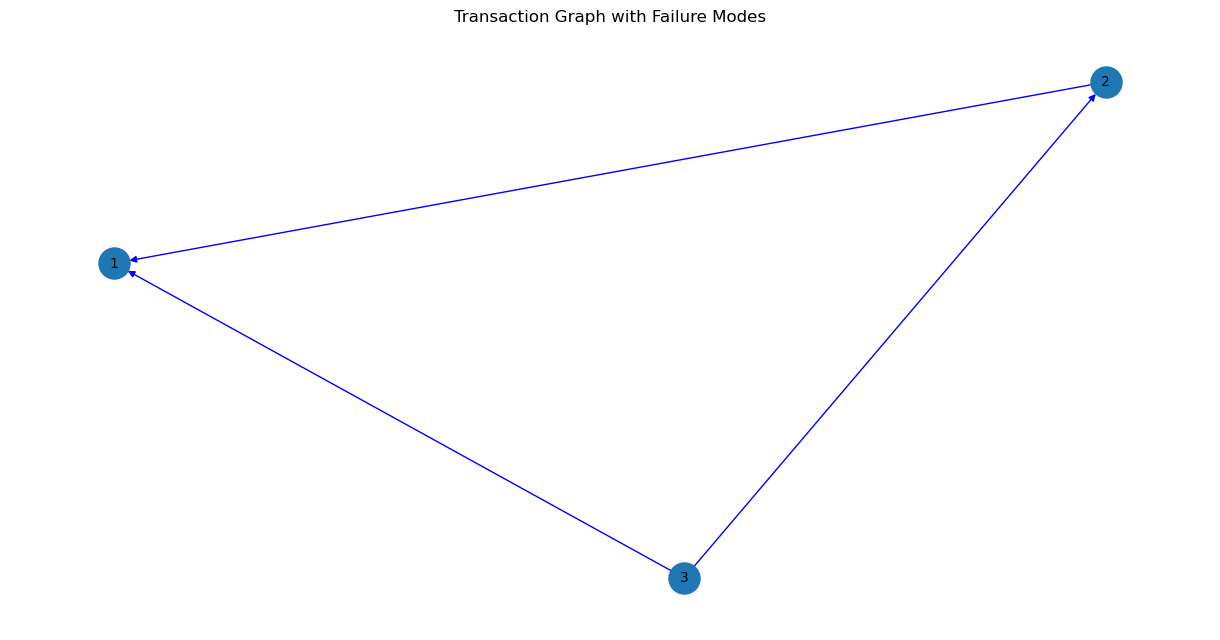

In [26]:
def visualize_graph():
    transactions = fetch_graph_data()

    if not transactions:
        print("⚠️ No transactions found!")
        return

    G = nx.DiGraph()  # Directed graph

    color_map = {
        "Normal": "blue",
        "HighFrequency": "red",
        "LargeTransaction": "orange",
        "RepeatedFailures": "purple"
    }

    for source, target, failure_mode in transactions:
        G.add_edge(source, target, color=color_map.get(failure_mode, "blue"))

    # Set node colors based on failure mode
    edge_colors = [G[u][v]["color"] for u, v in G.edges()]
    
    plt.figure(figsize=(12, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, edge_color=edge_colors, node_size=500, font_size=10)
    plt.title("Transaction Graph with Failure Modes")
    plt.show()

# Run visualization
visualize_graph()
